In [1]:
import os
import yaml
import pickle
import numpy as np
import pandas as pd
import itertools
import scipy
import torch
import torch_geometric.datasets as datasets
import torch_geometric.data as Data
from torch_geometric.loader import DataLoader
import torch_geometric.transforms as transforms
import networkx as nx
from torch_geometric.utils.convert import to_networkx
import matplotlib.pyplot as plt

from produce_dataset import *

import torch.nn.functional as F
from torch_geometric.nn import GCNConv

In [2]:
#one event from: Phase2HLTTDRWinter20DIGI/DsToTauTo3Mu_TuneCP5_14TeV-pythia8/GEN-SIM-DIGI-RAW/PU200_withNewMB_110X_mcRun4_realistic_v3_ext1-v1/

ntuple_dir = '/ecoderemdvol/econ_ntuples/DsToTauTo3Mu/'
root_dir = 'FloatingpointAutoEncoderEMDAEMSEttbarDummyHistomaxGenmatchGenclustersntuple'

df_econ = loadEconData(ntuple_dir,root_dir,'econ_data.csv',False)

df_gen = loadGenData(ntuple_dir,root_dir,'gen_data.csv')

In [3]:
df_nodes=df_econ[['ECON_0', 'ECON_1', 'ECON_2', 'ECON_3', 'ECON_4', 'ECON_5', 'ECON_6',
       'ECON_7', 'ECON_8', 'ECON_9', 'ECON_10', 'ECON_11', 'ECON_12','ECON_13', 'ECON_14', 'ECON_15', 
        'wafer_energy', 'tc_eta', 'tc_phi']]
df_nodes.reset_index(inplace=True)

count = (df_econ['wafer_energy'] != 0).sum()
print('e wafers: '+str(count)+', out of: '+str(df_econ.size)+' or  '+ str(round((count/df_econ.size)*100,2))+'%')

e wafers: 1904, out of: 310152 or  0.61%


In [4]:
cols = ['ECON_0', 'ECON_1', 'ECON_2', 'ECON_3', 'ECON_4', 'ECON_5', 'ECON_6',
       'ECON_7', 'ECON_8', 'ECON_9', 'ECON_10', 'ECON_11', 'ECON_12','ECON_13', 'ECON_14', 'ECON_15']

#find sum of columns specified 
df_nodes['sum'] = df_nodes[cols].sum(axis=1);

/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


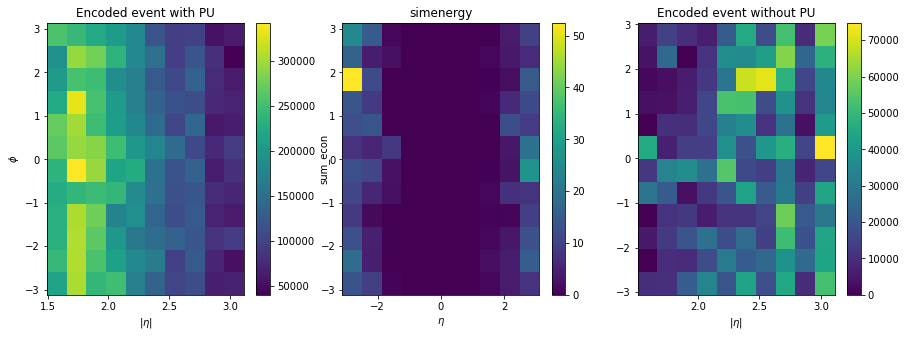

In [5]:
fig, axes = plt.subplots(1,3,figsize=(15,5))
plt.subplot(1,3,1)
h1 = plt.hist2d(x=abs(df_nodes['tc_eta']),y=df_nodes['tc_phi'],bins=(10,12),weights=df_nodes['sum'])
fig.colorbar(h1[3],label='sum_econ')
plt.xlabel(r'$|\eta|$');
plt.ylabel(r'$\phi$');
plt.title('Encoded event with PU');
plt.subplot(1,3,2)
h2 = plt.hist2d(x=df_nodes['tc_eta'],y=df_nodes['tc_phi'],bins=(10,12),weights=df_nodes['wafer_energy'])
fig.colorbar(h2[3])
plt.xlabel(r'$\eta$');
plt.title('simenergy');
df_nodes_w_simenergy = df_nodes[df_nodes.wafer_energy>0]
plt.subplot(1,3,3)
h3 = plt.hist2d(x=abs(df_nodes_w_simenergy['tc_eta']),y=df_nodes_w_simenergy['tc_phi'],bins=(10,12),weights=df_nodes_w_simenergy['sum'])
fig.colorbar(h3[3])
plt.xlabel(r'$|\eta|$');
plt.title('Encoded event without PU');

event for 20 electrons

In [6]:
def build_graph(df_econ,
            df_gen,
            zside_select,
            phi_min,
            phi_max):
    
    if zside_select !=0:
        df_econ = df_econ[df_econ.zside == zside_select]

    #only choose wafers in some phi range now
    
    df_econ = df_econ[df_econ.tc_phi>phi_min][df_econ.tc_phi<phi_max];
    
    df_nodes=df_econ[['ECON_0', 'ECON_1', 'ECON_2', 'ECON_3', 'ECON_4', 'ECON_5', 'ECON_6',
           'ECON_7', 'ECON_8', 'ECON_9', 'ECON_10', 'ECON_11', 'ECON_12','ECON_13', 'ECON_14', 'ECON_15', 
            'wafer_energy', 'tc_eta', 'tc_phi']]
    df_nodes.reset_index(inplace=True)
    
    embeddings = torch.tensor(df_nodes.values)

    eta=df_nodes['tc_eta']
    phi=df_nodes['tc_phi']
    idx = range(len(eta))
    indices_i = np.array([i for i,j in itertools.product(idx,idx)])
    indices_j = np.array([j for i,j in itertools.product(idx,idx)])

    del_R = np.empty([len(eta),len(eta)])
    del_R.shape

    for (i, j) in zip(indices_i,indices_j):
        del_R[i][j]=np.sqrt((eta[i]-eta[j])**2+((phi[i]-phi[j])%(2*np.pi))**2)

    del_R = torch.tensor(del_R)

    adj = np.zeros([len(eta),len(eta)])
    for (i, j) in zip(indices_i,indices_j):
        if del_R[i][j] <0.045 and  del_R[i][j]> 0 :
            adj[i][j]=1.0

    adj=torch.tensor(adj) 

    edge_index = (adj > 0.0).nonzero().t()
    edge_index.shape

    #predict node level feature: PU vs electron per simenergy

    feature_df= df_econ['wafer_energy']
    labels = (feature_df.where(feature_df==0,other=1))
    features = torch.tensor(labels.values).to(torch.long)

    graph = Data.Data(x=embeddings, edge_index=edge_index, y=features)
    graph.num_classes=2
    return graph,df_nodes

In [7]:
#Choose only front endcap for training

#df_gen = (df_gen[df_gen.eta>0])
#df_gen.reset_index(drop=True,inplace=True)

In [8]:
graphs = []
cut_event_dfs=[]

In [9]:
phi_range = np.linspace(-np.pi,np.pi,20)

In [10]:
for gen_phi in phi_range:
    phi_min,phi_max= gen_phi-np.pi/12,gen_phi+np.pi/12
    graph, cut_event_df = build_graph(df_econ,df_gen,0,phi_min,phi_max)
    graphs.append(graph);
    cut_event_dfs.append(cut_event_df)  

/tmp/ipykernel_662/1296269495.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_econ = df_econ[df_econ.tc_phi>phi_min][df_econ.tc_phi<phi_max];


In [11]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(graphs[0].num_features, 16)
        self.conv2 = GCNConv(16, graphs[0].num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)


In [46]:
device = torch.device('cuda')
model = GCN().to(device)
model = model.double()

In [47]:
data = graphs[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [48]:
model.train()
for epoch in range(1000):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out,data.y)
    loss.backward()
    optimizer.step()

In [49]:
model.eval()
train_pred = model(data).argmax(dim=1)
correct = (train_pred == data.y).sum()
train_acc = int(correct)/graphs[0].y.size(dim=0)
print(f'Accuracy: {train_acc:.4f}')

Accuracy: 0.8734


In [50]:
xtest=train_pred.cpu().numpy()

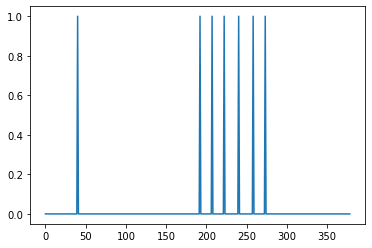

In [51]:
plt.plot(range(len(xtest)),xtest)

In [52]:
acc_array=[]
pred_array=[]
for graph in graphs:
    val_data=graph.to(device)
    pred = model(val_data).argmax(dim=1)
    pred_array.append(pred)
    correct = (pred == val_data.y).sum()
    acc = int(correct)/val_data.y.size(dim=0)
    acc_array.append(acc)
    #print(f'Accuracy: {acc:.4f}')

In [53]:
np.asarray(acc_array).mean()

0.85080266863577

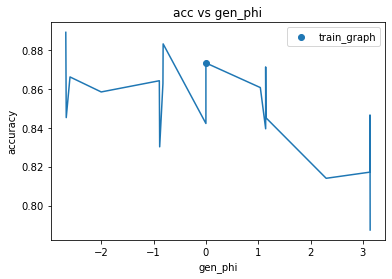

In [54]:
xs = df_gen['phi']
ys = acc_array

xs, ys = zip(*sorted(zip(xs, ys)))

plt.plot(xs, ys);
plt.scatter(df_gen['phi'][0],train_acc,label='train_graph');
plt.xlabel('gen_phi')
plt.ylabel('accuracy')
plt.legend()
plt.title('acc vs gen_phi');

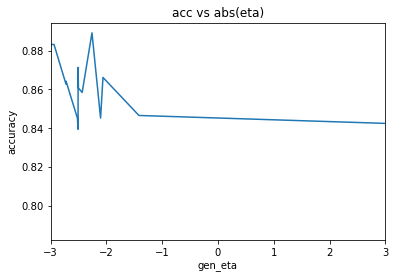

In [55]:
xs =(df_gen['eta'])
ys = acc_array

xs, ys = zip(*sorted(zip(xs, ys)))

plt.plot(xs, ys)
plt.xlim(-3,3)
plt.scatter(df_gen['eta'][0],train_acc)
plt.xlabel('gen_eta')
#plt.xscale('log')
plt.ylabel('accuracy')
plt.title('acc vs abs(eta)');

In [56]:
for i in range(20):
    cut_event_dfs[i]['pred_label'] =  pred_array[i].cpu().numpy()

In [57]:
test=cut_event_dfs[0]

In [58]:
GNN_PU_removed_event_dfs=[]
for i in range(20):
    app = cut_event_dfs[i]
    GNN_PU_removed_event_dfs.append(app[app.pred_label==1])

In [59]:
GNN_PU_removed_event=GNN_PU_removed_event_dfs[0]
for i in range(1,20):
    app = GNN_PU_removed_event_dfs[i]
    GNN_PU_removed_event=pd.concat([GNN_PU_removed_event,app])

In [60]:
GNN_PU_removed_event

,index,ECON_0,ECON_1,ECON_2,ECON_3,ECON_4,ECON_5,ECON_6,ECON_7,ECON_8,...,ECON_10,ECON_11,ECON_12,ECON_13,ECON_14,ECON_15,wafer_energy,tc_eta,tc_phi,pred_label
40,1360,0,128,0,320,128,0,64,64,64,...,64,128,192,0,64,64,0.000000,-2.000868,-2.976953,1
192,7014,0,64,64,64,192,0,128,128,64,...,64,128,128,128,64,128,0.063009,-2.023427,-2.984554,1
207,7540,0,128,128,0,256,0,128,64,64,...,64,0,64,256,64,64,0.079918,-2.011521,-2.987326,1
222,8089,0,96,128,176,96,0,128,64,112,...,176,96,160,80,80,112,0.043483,-2.014030,-2.980440,1
240,8664,0,140,144,60,128,0,104,84,112,...,100,144,172,92,120,132,0.377108,-2.008943,-2.984870,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,4059,0,192,64,64,192,0,64,64,192,...,128,256,128,192,64,128,0.000000,-2.009223,3.036521,1
114,4468,0,128,64,64,192,0,64,64,128,...,320,64,192,192,128,64,0.000000,1.653006,3.048055,1
133,4937,0,128,0,384,128,0,0,0,0,...,0,128,192,0,64,0,0.000000,1.634173,3.061863,1
167,5924,0,192,64,256,128,0,64,64,64,...,128,64,128,128,64,64,0.000000,1.630275,3.048949,1


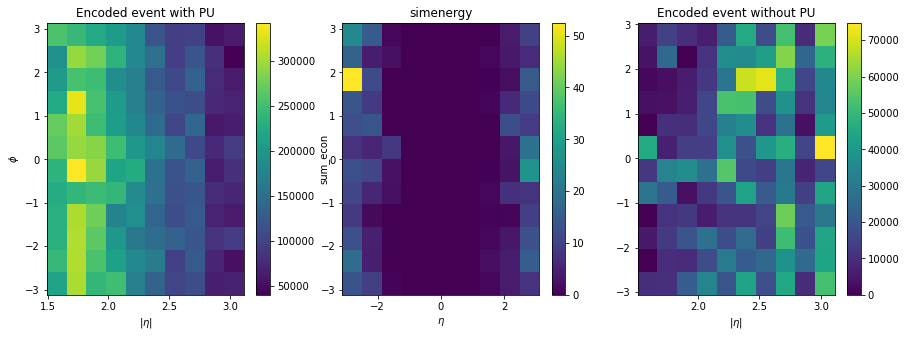

In [61]:
fig, axes = plt.subplots(1,3,figsize=(15,5))
plt.subplot(1,3,1)
h1 = plt.hist2d(x=abs(df_nodes['tc_eta']),y=df_nodes['tc_phi'],bins=(10,12),weights=df_nodes['sum'])
fig.colorbar(h1[3],label='sum_econ')
plt.xlabel(r'$|\eta|$');
plt.ylabel(r'$\phi$');
plt.title('Encoded event with PU');
plt.subplot(1,3,2)
h2 = plt.hist2d(x=df_nodes['tc_eta'],y=df_nodes['tc_phi'],bins=(10,12),weights=df_nodes['wafer_energy'])
fig.colorbar(h2[3])
plt.xlabel(r'$\eta$');
plt.title('simenergy');
df_nodes_w_simenergy = df_nodes[df_nodes.wafer_energy>0]
plt.subplot(1,3,3)
h3 = plt.hist2d(x=abs(df_nodes_w_simenergy['tc_eta']),y=df_nodes_w_simenergy['tc_phi'],bins=(10,12),weights=df_nodes_w_simenergy['sum'])
fig.colorbar(h3[3])
plt.xlabel(r'$|\eta|$');
plt.title('Encoded event without PU');

In [62]:
GNN_PU_removed_event['sum'] = GNN_PU_removed_event[cols].sum(axis=1);

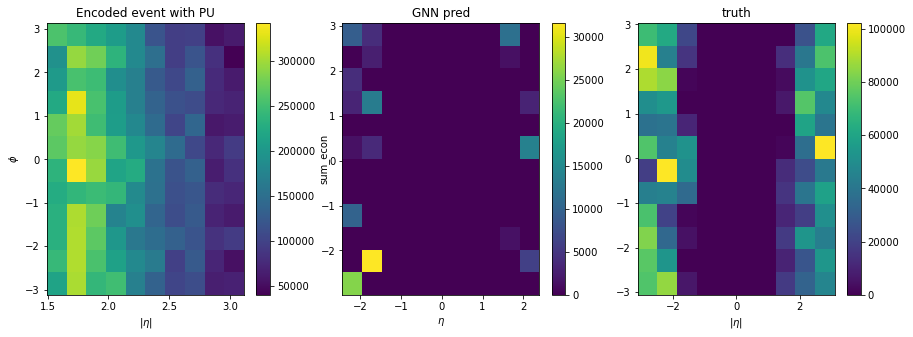

In [66]:
fig, axes = plt.subplots(1,3,figsize=(15,5))
plt.subplot(1,3,1)
h1 = plt.hist2d(x=abs(df_nodes['tc_eta']),y=df_nodes['tc_phi'],bins=(10,12),weights=df_nodes['sum'])
fig.colorbar(h1[3],label='sum_econ')
plt.xlabel(r'$|\eta|$');
plt.ylabel(r'$\phi$');
plt.title('Encoded event with PU');
plt.subplot(1,3,2)
h2 = plt.hist2d(x=GNN_PU_removed_event['tc_eta'],y=GNN_PU_removed_event['tc_phi'],bins=(10,12),weights=GNN_PU_removed_event['sum'])
fig.colorbar(h2[3])
plt.xlabel(r'$\eta$');
plt.title('GNN pred');
plt.subplot(1,3,3)
h3 = plt.hist2d(x=(df_nodes_w_simenergy['tc_eta']),y=df_nodes_w_simenergy['tc_phi'],bins=(10,12),weights=df_nodes_w_simenergy['sum'])
fig.colorbar(h3[3])
plt.xlabel(r'$|\eta|$');
plt.title('truth');
plt.savefig('dstau3mu.png',dpi=600)

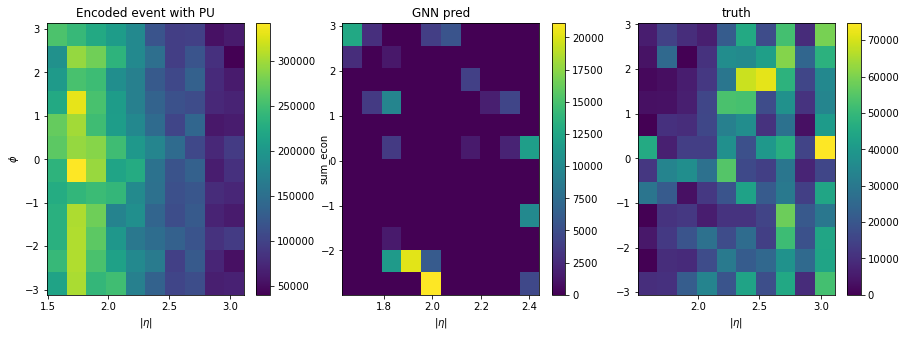

In [64]:
fig, axes = plt.subplots(1,3,figsize=(15,5))
plt.subplot(1,3,1)
h1 = plt.hist2d(x=abs(df_nodes['tc_eta']),y=df_nodes['tc_phi'],bins=(10,12),weights=df_nodes['sum'])
fig.colorbar(h1[3],label='sum_econ')
plt.xlabel(r'$|\eta|$');
plt.ylabel(r'$\phi$');
plt.title('Encoded event with PU');
plt.subplot(1,3,2)
h2 = plt.hist2d(x=abs(GNN_PU_removed_event['tc_eta']),y=GNN_PU_removed_event['tc_phi'],bins=(10,12),weights=GNN_PU_removed_event['sum'])
fig.colorbar(h2[3])
plt.xlabel(r'$|\eta|$');
plt.title('GNN pred');
plt.subplot(1,3,3)
h3 = plt.hist2d(x=abs(df_nodes_w_simenergy['tc_eta']),y=df_nodes_w_simenergy['tc_phi'],bins=(10,12),weights=df_nodes_w_simenergy['sum'])
fig.colorbar(h3[3])
plt.xlabel(r'$|\eta|$');
plt.title('truth');